# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

In this project, we are given a data set of $51,839$ samples of $32\times32$ labeled RGB images of German traffic signs ([German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)). Our goal to build, train, and analyize an image classifier inspired by the LeNet Convolutional Nueral Network (CNN) architecture.  We will perform data exploration, where we try to find some useful preprocessing steps that allows us to extract more useful features for classification, artifcally generate additional image samples through image transformations, we will also build a tensorflow CNN model, tune the model hyperparameters, analyize the classifer operating characteristics, and finally examen the model filters that are generated from the training of the CNN.  Many parts of this notebook are inspired by Alex Staravoitau's work (https://navoshta.com/traffic-signs-classification/) and the work of Pierre Sermanet and Yann LeCun (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

## Data Exploration and Augmentation

In [1]:
import warnings
warnings.filterwarnings('ignore')

# required packages
import pickle
import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# importing the data sets
training_file = 'data/train.p'
validation_file='data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

class_labels = pd.read_csv('signnames.csv')

### Basic Summary of the Data

In [4]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

print("Total data set size = ", n_train+n_validation+n_test)
print("-"*20)
print("Number of training examples =", n_train)
print("Number of validation examples = ", n_validation)
print("Number of testing examples =", n_test)
print("-"*20)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total data set size =  51839
--------------------
Number of training examples = 34799
Number of validation examples =  4410
Number of testing examples = 12630
--------------------
Image data shape = (32, 32, 3)
Number of classes = 43


Let's take a look at some of the examples in the training data set to get an idea of what we're working with.

In [5]:
# collecting images within the same classes
X_collections = []

for cls in range(n_classes):
    X_collections.append(X_train[y_train == cls])

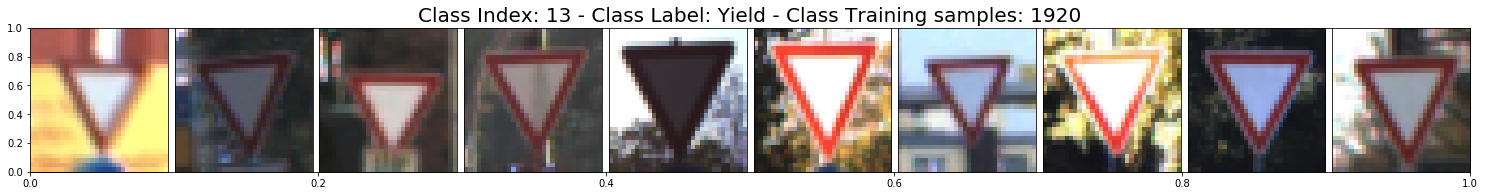

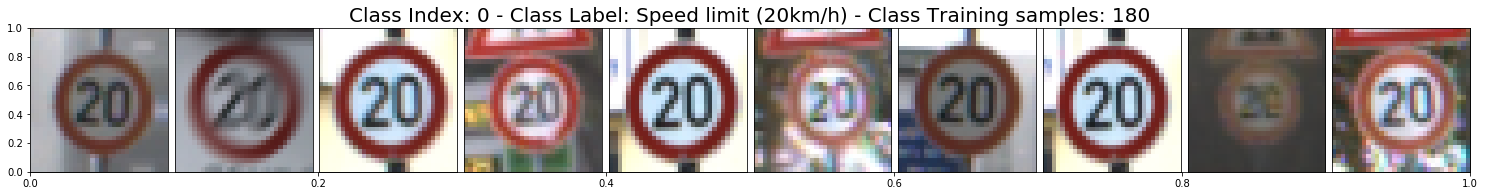

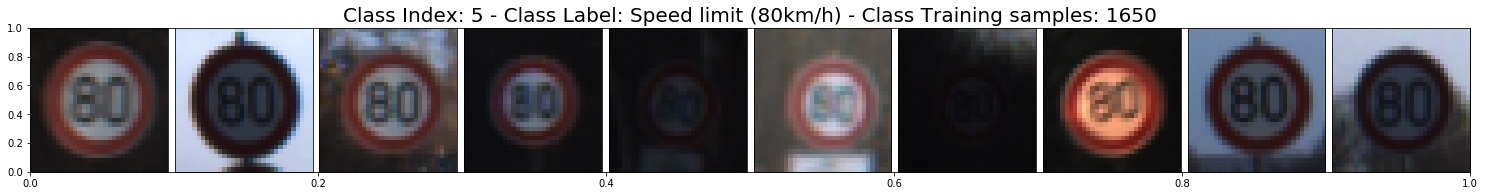

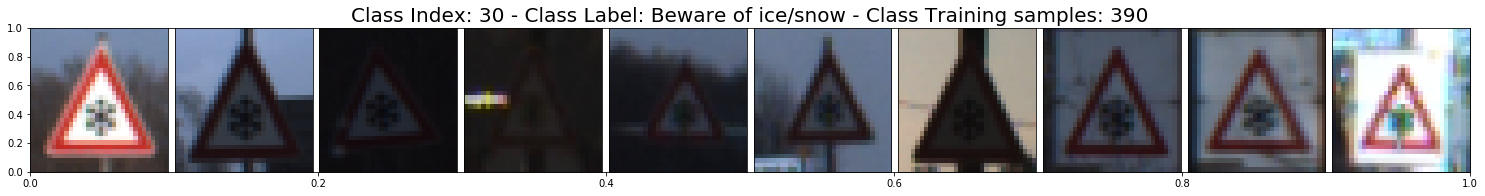

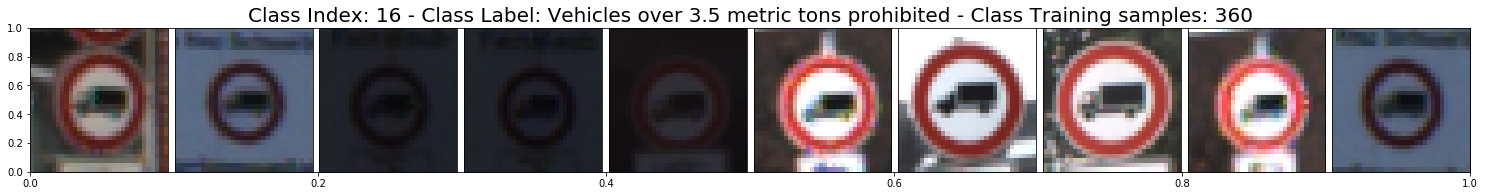

In [6]:
np.random.seed(1337)
rand_class_sample = np.random.choice(range(len(X_collections)),5,replace=False)

for cidx in rand_class_sample :
    clab = class_labels.values[cidx,1]
    title =("Class Index: %i - Class Label: %s - Class Training samples: %i" % (cidx,clab,len(X_collections[cidx])))
    fig = plt.figure(figsize = (20,2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    plt.title(title,fontsize=20)
    ridx = np.random.choice(range(len(X_collections[cidx])),10,replace=False)
    collection = X_collections[cidx][ridx]
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(collection[i],aspect="auto")
    plt.show()

Let's take a look at the distribution of examples per class.

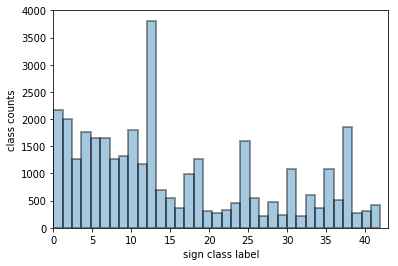

In [7]:
sns.distplot(y_train, kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel("sign class label")
plt.ylabel("class counts")
plt.xlim(0,43)
plt.show();

The un-even number of examples per class posses a challenge because if the classifier used none of the information within the image, and randomly sampled from this histogram its classification approximation, it would give a base accuracy of:

$P(\hat{y}=y) = \sum_\hat{y} \sum_y P(y)P(\hat{y})I(\hat{y}=y) =  \sum_y P(y)^2 = \sum_y \frac{N_y^2}{N^2} \approx 3.69\%$ 

versus when all classes have the same number of examples the base accuracy is 

$43 \frac{(N/43)^2}{N^2} = \frac{1}{43} \approx 2.32 \%$  so there is a slight bias in the dataset towards just guessing the more commonly occuring classes vs actually learning and determining something from the image data. We can correct for that by augmenting the dataset by artifcally generating new examples.

The dataset consists of images of traffic signs taken from various factors e.g. angles of incidence, brightness levels, backgrounds, image noise, sign orientation (rotation).  By transforming our training data set by applying rotations, persepective warps, noise addition, brightness changes, we can provide to the model more examples of what we're trying to classify, making it more likely we'll have similar images in the testing, and validation sets, and ultimately the real world to train against. Furthermore we can use this to even out the numbers of examples in each class such that we remove any inherent bias towards any one class.

In [5]:
# Augmenting the Dataset functions
def img_rotate(img,angle):
    tmp = np.copy(img)
    l,w,_ = tmp.shape

    M = cv2.getRotationMatrix2D((w/2,l/2),angle,1)
    dst = cv2.warpAffine(tmp,M,(w,l))
    
    # lots of geometery calcs were done to figure out how to
    # find the bounding box that doesn't have the black border
    # edges in a rotated image, this assumes l = w

    # conversion from degrees to radians
    a = angle*np.pi/180.
    
    # different bounds happen for positive angles vs negative ones
    if a > 0.0:
        denom = (np.cos(a)+np.sin(a))**2
        low = int(w*np.cos(a)*np.sin(a)/denom)
        hi = int(w*(1+np.cos(a)*np.sin(a))/denom)
    else:
        denom = 4*np.cos(a)*np.sin(a)-2
        low = int(w*np.sin(2*a)/denom)
        hi = int(w*(np.sin(2*a)-2)/denom)
        
    croped = dst[low:hi,low:hi]
    # reshaped
    dst = cv2.resize(croped,(l,w))
    return dst

def img_brightness_adjust(img,a=1.0,b=0.0):
    tmp = np.copy(img)
    for ch in range(3):
        tmp[:,:,ch] = np.clip(a*tmp[:,:,ch] + b, 0, 255)

    return tmp

def img_3chEqualizer(img):
    tmp = np.copy(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
    for ch in range(3):
        tmp[:,:,ch] = clahe.apply(tmp[:,:,ch])
    return tmp

def img_rand_perspective(img,scale=0.0):
    nrows,ncols,_ = img.shape
 
    lx = 0
    ly = 0
    hx = nrows
    hy = ncols
    
    # source coords  #(UL,LL,LR,UR)
    src = np.float32([[lx,ly],[lx,hy],[hx,hy],[hx,ly]]) 
    
    # destination coordinates
    dyscale = nrows/2.*scale
    dxscale = ncols/2.*scale
    # upper left deviation
    ULdx = np.int32(np.random.uniform(low=-dxscale,high=dxscale))
    ULdy = np.int32(np.random.uniform(low=-dyscale,high=dyscale))
    
    # lower left deviation
    LLdx = np.int32(np.random.uniform(low=-dxscale,high=dxscale))
    LLdy = np.int32(hy+np.random.uniform(low=-dyscale,high=dyscale))
    
    # lower right deviation
    LRdx = np.int32(hx+np.random.uniform(low=-dxscale,high=dxscale))
    LRdy = np.int32(hy+np.random.uniform(low=-dyscale,high=dyscale))
    
    # upper right deviation
    URdx = np.int32(hx+np.random.uniform(low=-dxscale,high=dxscale))
    URdy = np.int32(np.random.uniform(low=-dyscale,high=dyscale))
    
    dst = np.float32([[ULdx,ULdy],
                      [LLdx,LLdy],
                      [LRdx,LRdy],
                      [URdx,URdy]])
    
    # finding x bounds
    lowx = np.argmin(np.array([ncols/2.-ULdx,ncols/2.-LLdx]))
    lowx = [ULdx,LLdx][lowx]
    if lowx < 0:
        lowx = 0
    hix = np.argmin(np.array([URdx-ncols/2.,LRdx-ncols/2.]))
    hix = [URdx,LRdx][hix]

    # finding y bounds
    lowy = np.argmin(np.array([nrows/2.-ULdy,nrows/2.-URdy]))
    lowy = [ULdy,URdy][lowy]
    if lowy < 0:
        lowy = 0
    hiy = np.argmin(np.array([LLdy-nrows/2.,LRdy-nrows/2.]))
    hiy = [LLdy,LRdy][hiy]
    
    # get the linear warp matrix
    M = cv2.getPerspectiveTransform(src,dst)
    # apply warp matrix
    warped = cv2.warpPerspective(img,M,(int(nrows*1.5),int(ncols*1.5)),flags=cv2.INTER_LINEAR)
    
    warped = warped[lowy:hiy,lowx:hix]
    warped = cv2.resize(warped,(ncols,nrows))
    
    return warped


# valid reflections taken from Staravoitau's work
def generate_all_reflections(X_data,y_data):
    
    # reflect along horizontal, still be classified as the same class label
    horizontal_classes = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    # reflect along vertical, still be classified as the same class label
    vertical_classes = [1, 5, 12, 15, 17]
    # reflect along 45 degree still classified as the same class label
    diagonal_classes = [32, 40]
    # mapping of classes when a vertical reflection is applied are mapped to a new label
    cross_flippable = {19:20,33:34,36:37,38:39,20:19,34:33,37:36,39:38}
    
    n_classes = len(np.unique(y_data))
    
    X_augment = np.empty([0, X_data.shape[1], X_data.shape[2], X_data.shape[3]], dtype = X_data.dtype)
    y_augment = np.empty([0], dtype = y_train.dtype)
    
    for c in range(n_classes):
        
        collection = X_data[y_data==c]
        
        if c in horizontal_classes:
            reflected = collection[:,:,::-1,:]
            labels = np.array(len(reflected)*[c])
            X_augment = np.append(X_augment,reflected,axis=0)
            y_augment = np.append(y_augment,labels,axis=0)
        
        if c in vertical_classes:
            reflected = collection[:,::-1,:,:]
            labels = np.array(len(reflected)*[c])
            X_augment = np.append(X_augment,reflected,axis=0)
            y_augment = np.append(y_augment,labels,axis=0)
        
        if c in diagonal_classes:
            reflected = collection[:,::-1,::-1,:]
            labels = np.array(len(reflected)*[c])
            X_augment = np.append(X_augment,reflected,axis=0)
            y_augment = np.append(y_augment,labels,axis=0)
        """    
        if c in cross_flippable.keys():
            reflected = collection[:,::-1,::-1,:]
            labels = np.array(len(reflected)*[cross_flippable[c]])
            X_augment = np.append(X_augment,reflected,axis=0)
            y_augment = np.append(y_augment,labels,axis=0)
        """
        
    X_augment = np.append(X_data,X_augment,axis=0)
    y_augment = np.append(y_data,y_augment,axis=0)
    
    return([X_augment,y_augment])

In [9]:
X_aug,y_aug = generate_all_reflections(X_train,y_train)

In [10]:
X_train.shape

(34799, 32, 32, 3)

In [11]:
X_aug.shape

(52289, 32, 32, 3)

In [19]:
unique, counts = np.unique(y_aug, return_counts=True)
dict(zip(unique, counts))

{0: 180,
 1: 3960,
 2: 2010,
 3: 1260,
 4: 1770,
 5: 3300,
 6: 360,
 7: 1290,
 8: 1260,
 9: 1320,
 10: 1800,
 11: 2340,
 12: 5670,
 13: 3840,
 14: 690,
 15: 1620,
 16: 360,
 17: 2970,
 18: 2160,
 19: 180,
 20: 300,
 21: 270,
 22: 660,
 23: 450,
 24: 240,
 25: 1350,
 26: 1080,
 27: 210,
 28: 480,
 29: 240,
 30: 780,
 31: 690,
 32: 420,
 33: 599,
 34: 360,
 35: 2160,
 36: 330,
 37: 180,
 38: 1860,
 39: 270,
 40: 600,
 41: 210,
 42: 210}

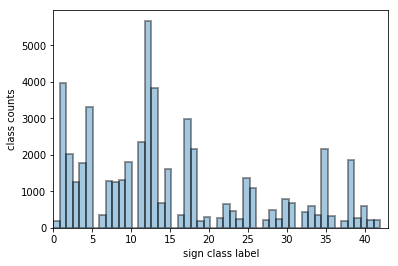

In [12]:
sns.distplot(y_aug, kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel("sign class label")
plt.ylabel("class counts")
plt.xlim(0,43)
plt.show();

### Rotations 

Rotations allow different views of the signage, but also introduces some artifacts that we don't want the classifier to be able to use as a feature.  So after some trignomotery I have cropped rotated images so that the artifcats are not present in the images. An example of a rotation and crop is done below.

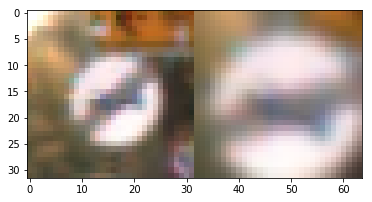

In [20]:
plt.imshow(np.hstack((X_train[123],img_rotate(X_train[123],-25.))));

### Brightness

Different times of the day, or lighting conditions can effect the exposure of each image, so by varying the brightness of an image, we're simulating different lighting conditions/times of the day for the images. An example is done below.

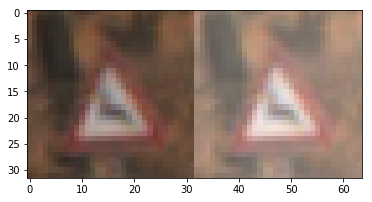

In [21]:
plt.imshow(np.hstack((X_train[300],img_brightness_adjust(X_train[300],a=1.0,b=60))));

### Equalization and Color spaces

Some of the images are quiet dark, and even for a human its hard to figure out what the sign is.  We can adjust the contrast in each image so that we spread out the differences between the dark and light pixels in a method known as histogram equalization. This will signficantly enhance the image contrast and allow those dark images to show more detail that makes it easier for a human to classify the images. An example is done below.

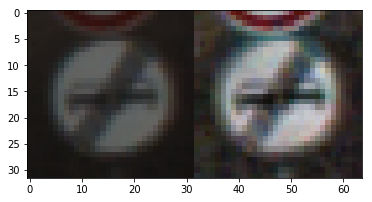

In [22]:
plt.imshow(np.hstack((X_train[20],img_3chEqualizer(X_train[20]))));

In [23]:
# Selecting especially dark examples
dark_img_idxs = np.mean(np.mean(np.mean(X_collections[12],axis=3),axis=1),axis=1)<20
dark_examples = X_collections[12][dark_img_idxs]

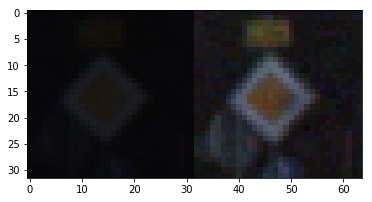

In [24]:
plt.imshow(np.hstack((dark_examples[0],img_3chEqualizer(dark_examples[0]))));

Unforuntely in this example we see a lot of noise in addition to the sign features we're looking for. It's not yet clear if our classifer will perform better on these examples where you can use the color information in the image, or changing to a different colorspace and using a particular channel may be a better feature for classification. An example of using the L channel in HLS space on the same image is shown below, and we will experiment with which feature set will be most useful.

In [25]:
hls = cv2.cvtColor(dark_examples[0],cv2.COLOR_RGB2HLS)

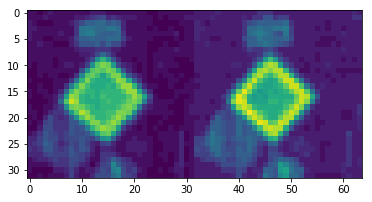

In [26]:
plt.imshow(np.hstack((dark_examples[0][:,:,1],hls[:,:,1])));

### Perspective Change

We also can add variety to our dataset by changing the persepective randomly in some of the images.  This allows our classifier to see more examples closer to real world examples that will likely be in the validation and test set, and therefore our classifier will generalize better. An example application is done below.

In [27]:
np.random.seed(1337)

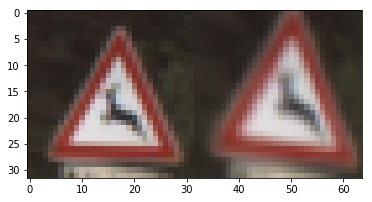

In [28]:
# note that the result of this function always is a random perspective change
# and you should not expect the same results for each run without setting
# the random seed, NOTE that you don't want to make scale much larger than 0.3
# as it will dramatically warp the image and make the region that viewable extremely
# small.  This will creating BAD examples to learn from an negatively impact your
# classifiers ability to learn 
plt.imshow(np.hstack((X_train[500],img_rand_perspective(X_train[500],scale=0.4))));

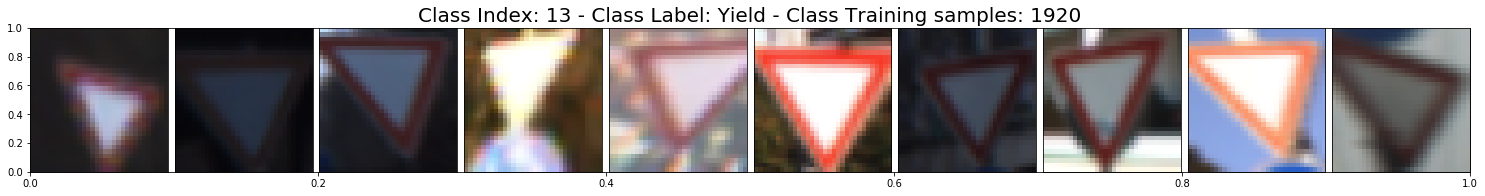

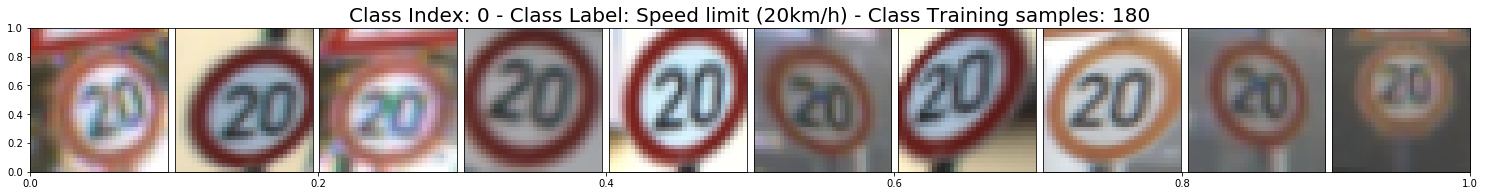

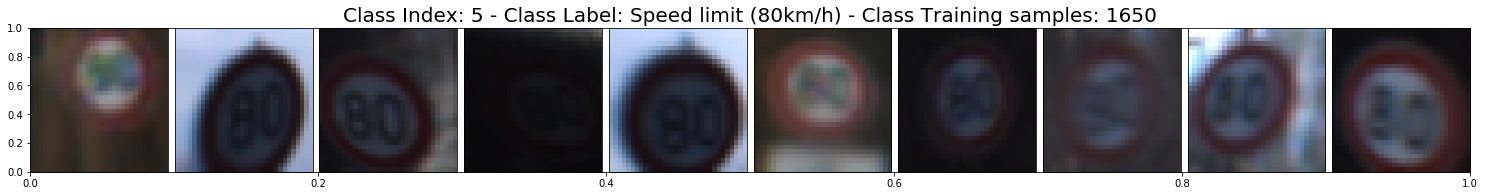

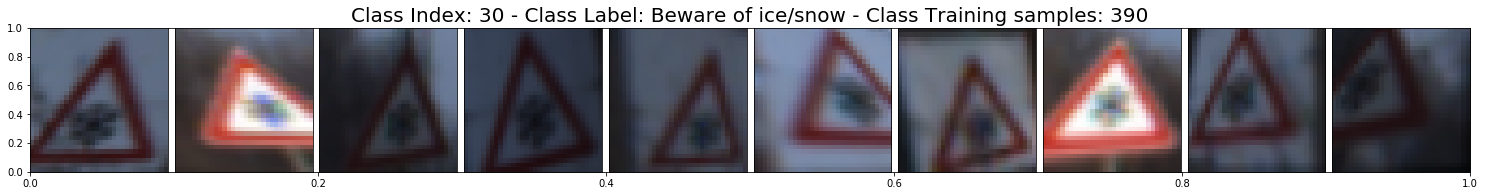

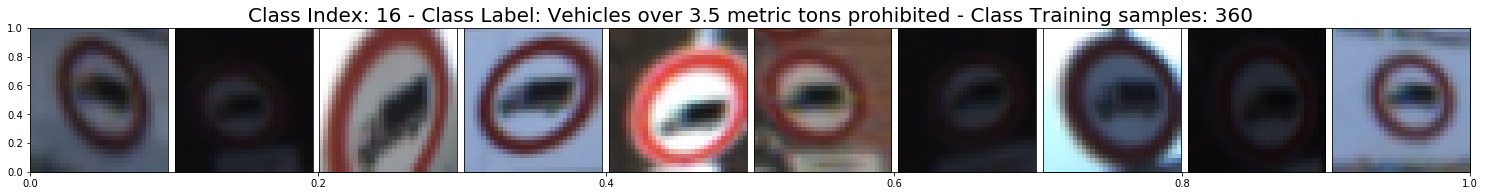

In [29]:
# Examples of dramatic warping
for cidx in rand_class_sample :
    clab = class_labels.values[cidx,1]
    title =("Class Index: %i - Class Label: %s - Class Training samples: %i" % (cidx,clab,len(X_collections[cidx])))
    fig = plt.figure(figsize = (20,2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    plt.title(title,fontsize=20)
    ridx = np.random.choice(range(len(X_collections[cidx])),10,replace=False)
    collection = X_collections[cidx][ridx]
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(img_rand_perspective(collection[i],scale=0.5),aspect="auto")
    plt.show()

There are also a class of rotations and reflections that could be generated to help give our classifier more examples to train against but I think these adjustments will allow good training without the reflects and rotations.

### Data Augmentation

So with these operations, we want to generate some fake data but taking into account we want to generate more images for those with lower number of examples, so that we have the same number of examples for each class of sign.  We'll also want to experiement with if apply the histogram equalization or just taking the single L channel of the HLS color space performs better or both. We'll also want to apply some sort of normalization technique, because the images are single or multiple channel pixel values between 0-255 we can rescale the pixel values to between 0 and 1 so that the CNN works more efficently and avoids overflows/underflowing-exploding/vanishing gradients.

In [30]:
n_samples_perclass = [len(X_collections[cidx]) for cidx in range(len(X_collections))]

In [31]:
# the class that has the most examples, has this many examples
max(n_samples_perclass)

2010

In [6]:
def augment_shuffle_norm(Xin_data, yin_data, nsamples_class=None, equalize=True, reshape_norm=False):
    # get some dimensions
    _,nrows,ncols,nchs = Xin_data.shape
    
    X_data = np.copy(Xin_data)
    y_data = np.copy(yin_data)
    
    if nsamples_class != None: # generate new data from the data with class equalization
        n_classes = len(np.unique(y_data))
        # initialize container for augmented data
        X_augmented = [[] for _ in range(n_classes)]
        #setting up the training target labels
        y_train = [[] for _ in range(n_classes)]
    
        for cls in range(n_classes): # for each class
            X_class = X_data[y_data == cls]
    
            ngenerate = nsamples_class-len(X_class)
            # if the class has more than nsamples_class just mix them up and give that back as the samples
            # for that class
            if ngenerate <= 0:
                # shuffle
                rand_idx = np.random.choice(range(len(X_class)),nsamples_class,replace=False)
                X_augmented[cls] = X_class[rand_idx]
                for nidx in range(len(X_augmented[cls])): # for each image apply
                    if equalize==True: # turn this on or off if you want to include hist eql in the RGB space
                        X_augmented[cls][nidx] = img_3chEqualizer(X_augmented[cls][nidx])
                    X_augmented[cls][nidx] = cv2.cvtColor(X_augmented[cls][nidx],cv2.COLOR_RGB2HLS)
            else:
                # if there aren't enough samples generate some modifed images where
                # the modifications are done randomly
                # shuffle
                rand_idx = np.random.choice(range(len(X_class)),ngenerate,replace=True)
                augset = X_class[rand_idx]
                for nidx in range(len(augset)): # for each image apply
                    # apply random rotation
                    rangle = np.random.uniform(low=-20.0,high=20)
                    augset[nidx] = img_rotate(augset[nidx],rangle)
                    # apply random brightening/darkening
                    rmag = np.random.uniform(low=-20,high=20)
                    augset[nidx] = img_brightness_adjust(augset[nidx],a=1.0,b=rmag)
                    
                    # apply random minor persepective change
                    augset[nidx] = img_rand_perspective(augset[nidx],scale=0.27)
                    
                    if equalize==True:
                        augset[nidx] = img_3chEqualizer(augset[nidx])
                    augset[nidx] = cv2.cvtColor(augset[nidx],cv2.COLOR_RGB2HLS)
        
                # join old set and augmented set
                X_augmented[cls] = np.vstack((X_class,augset))
            
            # generate the labels
            y_train[cls] = nsamples_class*[cls]
    
    else: # don't generate any new data just apply the transformations
        print("NO data generation")
        for nidx in range(len(X_data)): # for each image apply
            if equalize==True:
                X_data[nidx] = img_3chEqualizer(X_data[nidx])
            X_data[nidx] = cv2.cvtColor(X_data[nidx],cv2.COLOR_RGB2HLS)
        
        # normalize if selected
        if reshape_norm==True:
            print("Normalizing and shuffling")
            X_data = np.array(X_data)/255.
            X_data = X_data.reshape(-1,nrows,ncols,nchs)
            y_train = y_data.reshape(-1)
            
            # final shuffle
            len_Xdat = len(X_data)
            ridx = np.random.choice(range(len_Xdat),len_Xdat,replace=False)
            X_data = X_data[ridx]
            y_train = y_train[ridx]
        
        return([X_data,y_train])
    
    # ok if you make it here then all the data has been augmented and collected
    # now to reshape it and normalize it
    y_train = np.array(y_train)
    
    if reshape_norm==True:
        X_augmented = np.array(X_augmented)
        X_augmented = X_augmented.reshape(-1,nrows,ncols,nchs)
        X_augmented = X_augmented/255.
        y_train = y_train.reshape(-1)
        
        # final shuffle
        len_Xaug = len(X_augmented)
        ridx = np.random.choice(range(len_Xaug),len_Xaug,replace=False)
        X_augmented = X_augmented[ridx]
        y_train = y_train[ridx]
    
    return([X_augmented,y_train])        

Lets look some random samples of the augmented dataset below to make sure they look right, by looking at the L-channel in some sample images.

In [33]:
X_train_aug,y_train_aug = augment_shuffle_norm(X_aug, y_aug, nsamples_class=50, equalize=True, reshape_norm=False)

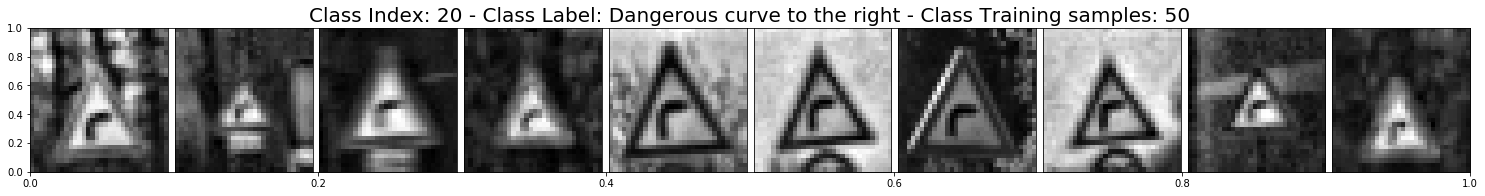

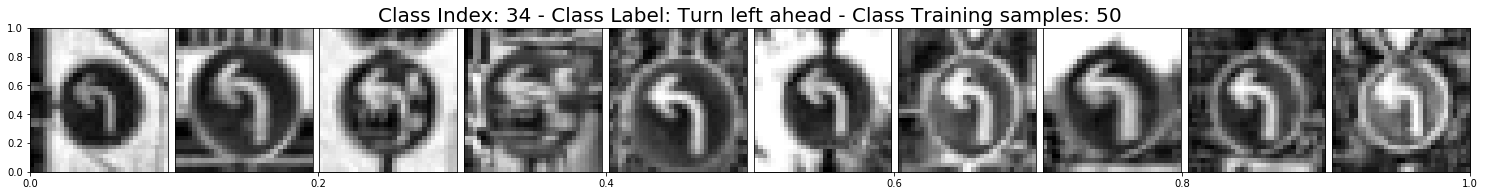

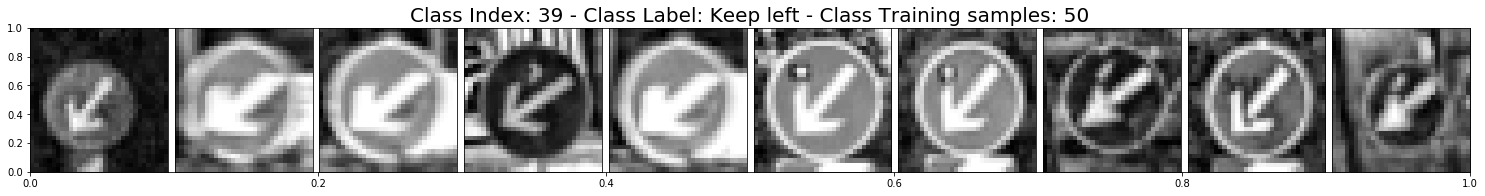

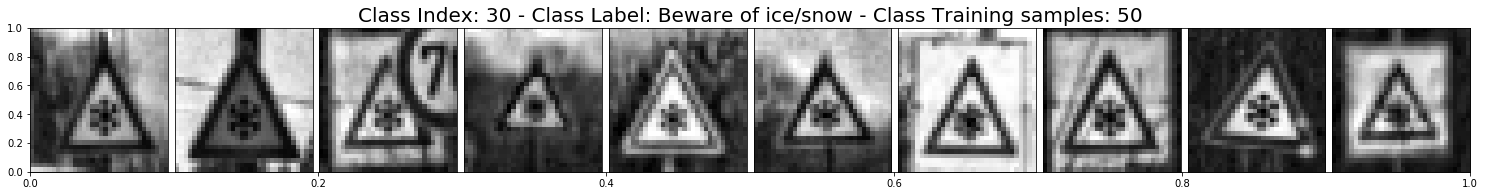

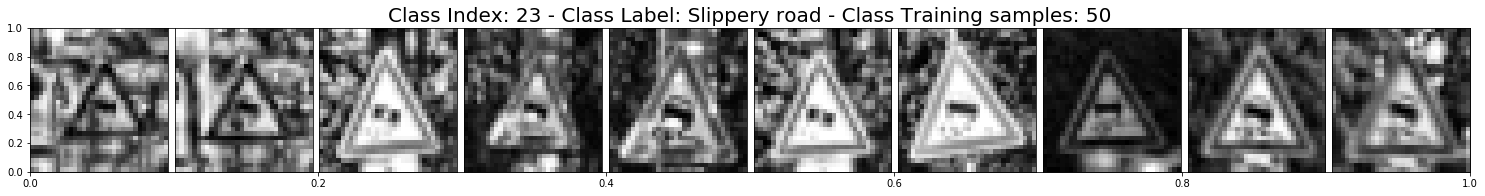

In [34]:
rand_class_sample = np.random.choice(range(len(X_train_aug)),5,replace=False)

nsamples_row = 10 # number of samples in each class to display

for cidx in rand_class_sample:
    cls = y_train_aug[cidx][0]
    clab = class_labels.values[cls,1]
    title=("Class Index: %i - Class Label: %s - Class Training samples: %i" % (cidx,clab,len(X_train_aug[cidx])))
    fig = plt.figure(figsize = (20,2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    plt.title(title,fontsize=20)
    
    ridx = np.random.choice(range(len(X_train_aug[cidx])),nsamples_row,replace=False)
    collection = X_train_aug[cidx][ridx]
    for i in range(nsamples_row):
        axis = fig.add_subplot(1, nsamples_row, i + 1, xticks=[], yticks=[])
        axis.imshow(collection[i][:,:,1],aspect="auto",cmap='gray')
    plt.show()

Okay they look good so lets make a much bigger data set to train with and apply the same preprocessing steps to the validation set, making sure not to generate any new examples on the validation set, and applying normalization and reshaping in this case.

In [37]:
np.random.seed(1337) # make sure we get the same training data everytime we run this
X_train_aug,y_train_aug = augment_shuffle_norm(X_aug, y_aug,nsamples_class=10000,equalize=True,reshape_norm=True)

In [38]:
#augmented trainning data in GB
print("Training data set is (GB): ", np.round((X_train_aug.nbytes)/(1024.)**3,2))

Training data set is (GB):  9.84


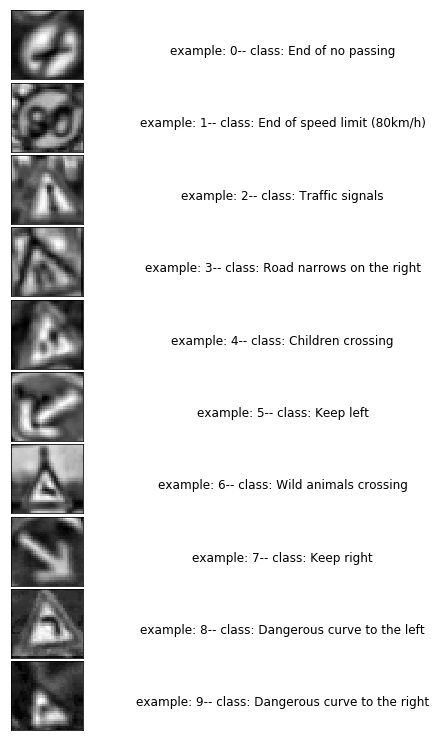

In [39]:
# Just make sure the train set looks correctly labeled, and shuffled
nsamples_col = 10
fig = plt.figure(figsize = (1,nsamples_col))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
ridx = [n for n in range(nsamples_row)]

for i in range(nsamples_col):
    cls = y_train_aug[ridx[i]]
    clab = class_labels.values[cls,1]
    axis = fig.add_subplot(nsamples_col, 1, i + 1, xticks=[], yticks=[])
    axis.imshow(X_train_aug[ridx[i]][:,:,1],aspect="auto",cmap='gray')
    axis.yaxis.set_label_position("right")
    axis.set_ylabel('example: '+str(i)+'-- class: '+clab,rotation=0, fontsize=12, labelpad=200)
plt.show()

In [40]:
# How many training examples do i have now?
X_train_aug.shape

(430000, 32, 32, 3)

In [41]:
# Verify the labels are the correct shape
y_train_aug.shape

(430000,)

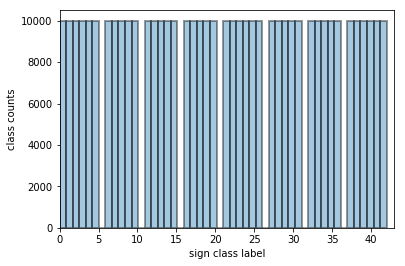

In [42]:
sns.distplot(y_train_aug, kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel("sign class label")
plt.ylabel("class counts")
plt.xlim(0,43)
plt.show();

In [43]:
X_valid_aug,y_valid_aug = augment_shuffle_norm(X_valid, y_valid, nsamples_class=None,equalize=True,reshape_norm=True)

NO data generation
Normalizing and shuffling


In [44]:
X_valid_aug.shape

(4410, 32, 32, 3)

In [45]:
y_valid_aug.shape

(4410,)

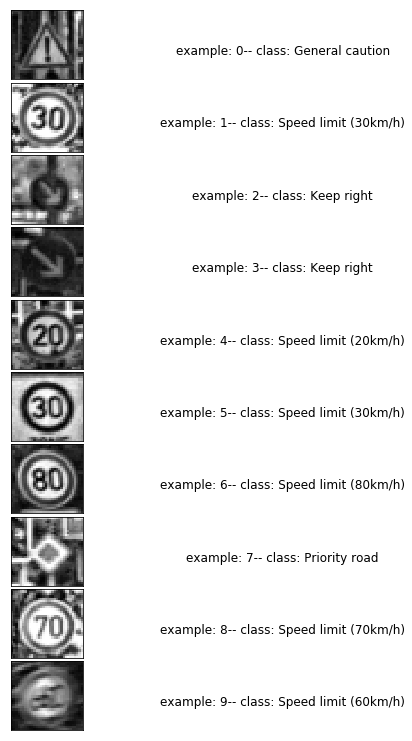

In [46]:
# Just make sure the validation set looks correctly labeled
nsamples_col = 10
fig = plt.figure(figsize = (1,nsamples_col))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
#ridx = np.random.choice(range(len(X_valid_aug)),nsamples_row,replace=False)
ridx = [n for n in range(nsamples_row)]
for i in range(nsamples_row):
    cls = y_valid_aug[ridx[i]]
    clab = class_labels.values[cls,1]
    axis = fig.add_subplot(nsamples_col,1, i + 1, xticks=[], yticks=[])
    axis.imshow(X_valid_aug[ridx[i]][:,:,1],aspect="auto",cmap='gray')
    axis.yaxis.set_label_position("right")
    axis.set_ylabel('example: '+str(i)+'-- class: '+clab,rotation=0, fontsize=12, labelpad=200)
    
plt.show()

In [47]:
# creating the 1 channel versions
X_train_aug_1ch = X_train_aug[:,:,:,1]
X_train_aug_1ch = X_train_aug_1ch.reshape(-1,32,32,1)

In [48]:
X_valid_aug_1ch = X_valid_aug[:,:,:,1]
X_valid_aug_1ch = X_valid_aug_1ch.reshape(-1,32,32,1)

In [31]:
# if you wanted to pickle this data set (but its quite big)
#aug_file = open('./train_aug_data.p', 'wb') 
#pickle.dump([X_train_aug,y_train_aug], aug_file)                      
#aug_file.close()

## Constructing a Convolutional Nueral Network Classifier

The model we're going to build is going to based on the LeNet-5 archietecture where we have 2-3 convolutional layers of filter size (5x5) with "Valid" padding because the signs do not appear to be located near the edges, so we shouldn't need to worry about SAME or VALID padding as implemented in tensorflow. We'll have to tune the number of filters at each level but generally we'll expand to more and more filters as we get deeper into the network.  After 2-3 convolution layers we attach the output to 2 fully connected layers where the final output will be the logit values for each class.

We will have to experiment with using single channel information or multi-channel information as the input to the network, as well as adding dropout regularization to the fully connected layers to help the network generalize for the validation and test sets. 

One really interesting modification to the LeNet architecture is suggested in Alex Staravoitau's work where he implements and mutli-feature scale classifier by connecting the output of the shallow convolutional networks to both the following convolutional layer but also the 1st fully connected layer.  This allows the fc layer to work on both complex features built up from lower level features but also combinations of lower level features (lines, edges, etc) and complex features together to make a robust classifier.

![Staravoitau's architecture](https://navoshta.com/images/posts/traffic-signs-classification/traffic-signs-architecture.png)

### Model Architecture

In [7]:
tf.reset_default_graph()

def CNN_MultiScaleFeatures(x, nclasses, fc_keep_prob=0.65, cov_keep_prob=0.9, nchannels=3):    
    # Arguments used for tf.truncated_normal, 
    # randomly defines variables for the weights 
    # and biases for each layer
    mu = 0.0
    sigma = 0.1
    
    # Layer 0: Convolutional with n_layer0, 1x1 filters
    # Input = 32x32x(nchannels). Output = 32x32x(n_layer0)
    n_layer0 = 32
    w0 = tf.Variable(tf.truncated_normal(shape=(5,5,nchannels,n_layer0),mean=mu,stddev=sigma))
    b0 = tf.Variable(tf.zeros(n_layer0))
    
    conv0 = tf.nn.conv2d(x,w0,strides=[1,1,1,1],padding='VALID',name='convolution_0')+b0
    conv0 = tf.nn.relu(conv0)
    
    # Pooling Layer. max or avg we will try both
    # Input = 32x32x(n_layer0). Output = 16x16x(n_layer0).
    pool0 = tf.nn.max_pool(conv0,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    pool0 = tf.nn.dropout(pool0,cov_keep_prob)
        
    # Layer 1: Convolutional with n_layer1, 5x5 filters
    # Input = 16x16x(nchannels). Output = 8x8x(n_layer1).
    n_layer1 = 64
    w1 = tf.Variable(tf.truncated_normal(shape=(5,5,n_layer0,n_layer1),mean=mu,stddev=sigma))
    b1 = tf.Variable(tf.zeros(n_layer1))
    
    conv1 = tf.nn.conv2d(pool0,w1,strides=[1,1,1,1],padding='VALID',name='convolution_1')+b1
    conv1 = tf.nn.relu(conv1)

    # Pooling Layer. max or avg we will try both
    # Input = 28x28x(n_layer1). Output = 14x14x(n_layer1).
    pool1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,1,1,1],padding='VALID')
    pool1 = tf.nn.dropout(pool1,cov_keep_prob)

    # Layer 2: Convolutional with n_layer2, 5x5 filters,
    # Input = 14x14x(n_layer1). Output = 10x10x(n_layer2).
    n_layer2 = 128
    w2 = tf.Variable(tf.truncated_normal(shape=(5,5,n_layer1,n_layer2),mean=mu,stddev=sigma))
    b2 = tf.Variable(tf.zeros(n_layer2))
    
    conv2 = tf.nn.conv2d(pool1,w2,strides=[1,1,1,1],padding='VALID',name='convolution_2')+b2
    conv2 = tf.nn.relu(conv2)

    # Pooling Layer. 
    # Input = 10x10x(n_layer2). Output = 5x5x(n_layer2).
    pool2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,1,1,1],padding='VALID')
    pool2 = tf.nn.dropout(pool2,cov_keep_prob)
    
    
    # Flatten conv layer0 and corse graining.
    # Input = 14x14x(n_layer1). Output = 14x14xn_layer1
    p0 = tf.nn.max_pool(pool0,ksize=[1,4,4,1],strides=[1,1,1,1],padding='VALID')
    shape = p0.get_shape().as_list()
    fc_pool0 = tf.reshape(p0, [-1, shape[1] * shape[2] * shape[3]])
    flat0_size = shape[1] * shape[2] * shape[3]

    # Flatten conv layer1. 
    # Input = 5x5x(n_layer2). Output = 5x5xn_layer2.
    p1 = tf.nn.max_pool(pool1,ksize=[1,2,2,1],strides=[1,1,1,1],padding='VALID')
    shape = p1.get_shape().as_list()
    fc_pool1 = tf.reshape(p1, [-1, shape[1] * shape[2] * shape[3]])  
    flat1_size = shape[1] * shape[2] * shape[3]
    
    # Flatten conv layer 2
    shape = pool2.get_shape().as_list()
    fc_pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])
    flat2_size = shape[1] * shape[2] * shape[3]
    
    
    flat = tf.concat([fc_pool0, fc_pool1, fc_pool2],1)
    fc_input_size = flat0_size+flat1_size+flat2_size
    #shape = pool2.get_shape().as_list()
    #flat = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])
    #fc_input_size = shape[1] * shape[2] * shape[3]
    
    # Layer 3: Fully Connected. 
    # Input = flat1_size + flat2_size. Output = fc1_size.
    #fc1_size = int(2*(flat1_size+flat2_size))
    fc1_size = 1024
    w3 = tf.Variable(tf.truncated_normal(shape=(fc_input_size,fc1_size),mean=mu,stddev=sigma))
    b3 = tf.Variable(tf.zeros(fc1_size))
    
    fc = tf.matmul(flat,w3)+b3
    fc = tf.nn.relu(fc)
    fc = tf.nn.dropout(fc,fc_keep_prob) # applying dropout to the FC layers
    
    # Layer 4: Fully Connected. Input = fc_size2. Output = nclasses.
    w4 = tf.Variable(tf.truncated_normal(shape=(fc1_size,nclasses),mean=mu,stddev=sigma))
    b4 = tf.Variable(tf.zeros(nclasses))

    logits = tf.matmul(fc,w4)+b4

    return logits

In [8]:
n_ch = 1 # color channels of the data you want to input into the network

# placeholder for the input shape of a batch of data
x = tf.placeholder(tf.float32, (None, 32, 32, n_ch))
# placeholder for the true class label
y = tf.placeholder(tf.int32, (None))

# function to map labels to one hot vectors
one_hot_y = tf.one_hot(y, n_classes)

# placeholder2 to specify the keep probablity
# for the dropout layers
fc_keep_prob = tf.placeholder(tf.float32)
cov_keep_prob = tf.placeholder(tf.float32)

In [9]:
# initial learning rate for ADAM optimizer
lr = 0.0001 #0.001 for pre-training

# constructing the CNN on the tf graph
logits = CNN_MultiScaleFeatures(x, n_classes, fc_keep_prob, cov_keep_prob, n_ch)
# x-entropy loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# constructing the optimzation function
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
training_operation = optimizer.minimize(loss)

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

# function that computes the mean accuracy over all the batches and gives
# the mean and standard deviation of the accuracy where the drop out is completed
# deactivated
def mean_batch_accuracy(X_data, y_data):
    num_examples = len(X_data)
    n_batches = 0
    batch_accuracy = 0.
    batch_var = 0.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, fc_keep_prob: 1.0,  cov_keep_prob: 1.0})
        batch_accuracy += accuracy
        batch_var += accuracy**2
        n_batches += 1

    mean = batch_accuracy/n_batches
    std = np.sqrt(batch_var/(n_batches-1) - mean**2)
    return [mean,std]


def mean_accuracy(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0.0
    n_batches=0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        acc = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, fc_keep_prob: 1.0,  cov_keep_prob: 1.0})
        total_accuracy += (acc*len(batch_x))
        n_batches+=1
        

    mean = total_accuracy/float(n_batches*BATCH_SIZE)
    std = 0.0
    return [mean,std]

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [59]:
SAVE_RATE = 4
EPOCHS = 4*4
BATCH_SIZE = 512 # you want to make sure this isnt too big or you wont have enough memory on the GPU
FC_KEEP_P = 0.6
COV_KEEP_P = 0.8
EARLY_STOP_TOLERANCE = 0.1

sample_memory_footprint_MB = (X_train_aug[0].nbytes)/(1024.)**2 

with tf.Session() as sess:
    print("Initializing variables...")
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.')) # used to continue training from a chkpt
    if n_ch == 3:
        num_examples = len(X_train_aug)
    else:
        num_examples = len(X_train_aug_1ch)
        
    prev_valid_acc = None
    estop_cntr = 1
    
    print("Training on "+str(num_examples)+" samples -- with n_ch: ", n_ch)
    print("Samples per Batch: ", BATCH_SIZE," -- Batch Memory Size: ", int(BATCH_SIZE*sample_memory_footprint_MB),"(MB) -- No. Batches Per Epoch: ", num_examples//BATCH_SIZE)
    print("Fully Connected Layer Dropout keep prob: ", FC_KEEP_P," -- Conv Layers Dropout keep prob: ", COV_KEEP_P)
    print()
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            if n_ch == 3:
                batch_x, batch_y = X_train_aug[offset:end], y_train_aug[offset:end]
            else:
                batch_x, batch_y = X_train_aug_1ch[offset:end], y_train_aug[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, fc_keep_prob: FC_KEEP_P, cov_keep_prob: COV_KEEP_P})
        
        if (i+1)%SAVE_RATE== 0: # only save every save_rate epochs so we don't run out of storage space.
            if n_ch == 3:
                train_accuracy,train_std = mean_accuracy(X_train_aug, y_train_aug)
                valid_accuracy,valid_std = mean_accuracy(X_valid_aug, y_valid_aug)
            else:
                train_accuracy,train_std = mean_accuracy(X_train_aug_1ch, y_train_aug)
                valid_accuracy,valid_std = mean_accuracy(X_valid_aug_1ch, y_valid_aug)
    
            print("Train Accuracy = {:.3f}+-{:.3f}, Validation Accuracy = {:.3f}+-{:.3f}".format(train_accuracy,train_std,valid_accuracy,valid_std))
            print()
            saver.save(sess, './lenet_tf_chkpts_ftune')
            print("Model saved")
            
            if prev_valid_acc != None:
                delta = (valid_accuracy - prev_valid_acc) # should be negative or approx stable at 0.0
                if delta < 0.0 or abs(delta) < EARLY_STOP_TOLERANCE:
                    prev_valid_acc = valid_accuracy
                    estop_cntr = 1
                elif estop_cntr == 2:
                    print("2 save check points passed with failure to improve or stablize validation accuracy.")
                    print("Early stopping at EPOCH: ", i)
                    break
                else:
                    estop_cntr += 1
                    prev_valid_acc = valid_accuracy

Initializing variables...
INFO:tensorflow:Restoring parameters from ./lenet_tf_chkpts
Training on 430000 samples -- with n_ch:  1
Samples per Batch:  512  -- Batch Memory Size:  12 (MB) -- No. Batches Per Epoch:  839
Fully Connected Layer Dropout keep prob:  0.6  -- Conv Layers Dropout keep prob:  0.8

EPOCH 1 ...
EPOCH 2 ...
EPOCH 3 ...
EPOCH 4 ...
Train Accuracy = 1.000+-0.000, Validation Accuracy = 0.949+-0.000

Model saved
EPOCH 5 ...
EPOCH 6 ...
EPOCH 7 ...
EPOCH 8 ...
Train Accuracy = 1.000+-0.000, Validation Accuracy = 0.948+-0.000

Model saved
EPOCH 9 ...
EPOCH 10 ...
EPOCH 11 ...
EPOCH 12 ...
Train Accuracy = 1.000+-0.000, Validation Accuracy = 0.949+-0.000

Model saved
EPOCH 13 ...
EPOCH 14 ...
EPOCH 15 ...
EPOCH 16 ...
Train Accuracy = 1.000+-0.000, Validation Accuracy = 0.947+-0.000

Model saved


258000 samples, 28 Epochs, 1 channel, No Equaliation, Validation Score 0.925, Train Score 0.999
258000 samples, 28 Epochs, 3 channel, No Equalization, Validation Score 0.899 , Train Score 0.999
258000 samples, 28 Epochs, 3 channel, Yes Equalization, Validation Score 0.908, Train Score 0.999
258000 samples, 28 Epochs, 1 channel, Yes Equalization, Validation Score 0.938, Train Score 1.0

258000 samples, 3 layer Cov No multiscale features Layer, 28 Epochs, 1 channel, Yes Equalization, Validation Score 0.937, Train Score 0.999

430000 samples, 3 layer conv, multiscaled, 20 Epochs, 16 Fine tune Epochs, 1 ch, Yes Equalizaotin, Vlaidation score 0.947, Train acc 1.0

344000 20 EPOCHS, 1 Channel, Y Equal, Valid 0.940, Train Score 0.999

with equalization validation 0.979

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
# 50 sign -- https://cdn-images-1.medium.com/max/1600/1*AMzlIufTY2fDMMsFQyvUrg.png
# 30 sign -- https://www.thelocal.de/userdata/images/1526310063_Yield%20sign%20.jpg
# right turn sign -- https://cdn.xl.thumbs.canstockphoto.ie/turn-right-sign-regulatory-signs-turn-right-ahead-traffic-sign-stock-photo_csp38482526.jpg
# uneven road -- https://www.howtogermany.com/images/roadsigns1.jpg
# wildlife sign -- https://www.howtogermany.com/images/roadsigns1.jpg

In [37]:
X_online_pre,y_online_pre = augment_shuffle_norm(X_online, y_online,nsamples_class=None,equalize=True,reshape_norm=True)

### Predict the Sign Type for Each Image

In [38]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(tf.argmax(logits, 1),feed_dict={x: X_online_pre,\
                                                           fc_keep_prob: 1.0,cov_keep_prob: 1.0}

### Analyze Performance

In [39]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [40]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [41]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")